# This Notebook tries to find patterns in the scores for different packages (Lethola / Psi4 / PySCF)

First we take a look at the data at hand. 

In [17]:
import pandas as pd
from openbabel import pybel
import numpy as np
from utils import *

In [18]:
psi4_data = pd.read_csv("../data/psi4_first_run.csv")
pyscf_data = pd.read_csv("../data/pyscf_first_run.csv")
lethola_data = pd.read_csv("../data/lethola_all.csv")

lethola_data.head()


molecule    gwh   core    sad  sadno  huckel    gsz  lda-x  cap-x  \
0           ch  0.501  0.557  0.739  0.877   0.937  0.862  0.851  0.868   
1          cch  0.504  0.693  0.833  0.962   0.945  0.931  0.966  0.965   
2        ch2ch  0.493  0.603  0.856  0.960   0.960  0.934  0.968  0.968   
3     Ti(BH4)3  0.608  0.614  0.897  0.972   0.924  0.809  0.959  0.963   
4  cyclopropyl  0.515  0.576  0.880  0.970   0.973  0.929  0.968  0.967   

   cha-x  table_id                                  type_name method     base  \
0  0.843         6   Non-neutral and/or non-singlet molecules     HF  pcseg-0   
1  0.966         6   Non-neutral and/or non-singlet molecules     HF  pcseg-0   
2  0.969         6   Non-neutral and/or non-singlet molecules     HF  pcseg-0   
3  0.967         6   Non-neutral and/or non-singlet molecules     HF  pcseg-0   
4  0.970         6   Non-neutral and/or non-singlet molecules     HF  pcseg-0   

  benchmark_metric  
0          f-score  
1          f-score  
2          f-score  
3          f-score  
4          f-score

## Add smiles and inchi keys to the data

In [19]:
# preproc - we add iupac names to the data! 
file_paths = get_xyz_file_paths("../data/geometries")
unique_mols = psi4_data["molecule"].unique()

assert [m==n for m,n in zip(unique_mols, lethola_data["molecule"].unique())] # check for my sanity

def convert_to_iupac(name, output_format): 
    filepath = [x for x in file_paths if f"/{name}.xyz" in x]
    assert len(filepath) == 1
    filepath = filepath[0]
    try: 
        mol = pybel.readstring("xyz", open(filepath).read())
    except FileNotFoundError: 
        print(f"Could not find {name}.xyz")
        return None
    return mol.write(output_format) if mol else None


unique_mols_inchi = {x: convert_to_iupac(x, "inchi") for x in unique_mols}
unique_mols_smi = {x: convert_to_iupac(x, "smi") for x in unique_mols}

psi4_data["inchi"] = psi4_data["molecule"].map(unique_mols_inchi)
psi4_data["smi"] = psi4_data["molecule"].map(unique_mols_smi)

lethola_data["inchi"] = lethola_data["molecule"].map(unique_mols_inchi)
lethola_data["smi"] = lethola_data["molecule"].map(unique_mols_smi)

pyscf_data["inchi"] = pyscf_data["molecule"].map(unique_mols_inchi)
pyscf_data["smi"] = pyscf_data["molecule"].map(unique_mols_smi)

*** Open Babel Warning  in InChI code
  molecule "ch" dataset "non-multireference W4-17" charge 0 multiplicity 2 :Accepted unusual valence(s): C(1)
*** Open Babel Warning  in InChI code
  molecule "cch" dataset "non-multireference W4-17" charge 0 multiplicity 2 :Accepted unusual valence(s): C(3)
*** Open Babel Warning  in InChI code
  molecule "ch2ch" dataset "non-multireference W4-17" charge 0 multiplicity 2 :Accepted unusual valence(s): C(3)
*** Open Babel Warning  in InChI code
  molecule "Ti(BH4)3" dataset "Bühl 2006" charge 0 multiplicity 2 :Accepted unusual valence(s): B(4)
*** Open Babel Warning  in InChI code
  molecule "cyclopropyl" dataset "non-multireference W4-17" charge 0 multiplicity 2 :Accepted unusual valence(s): C(3)
*** Open Babel Warning  in InChI code
  molecule "cn" dataset "non-multireference W4-17" charge 0 multiplicity 2 :Accepted unusual valence(s): C(3)
*** Open Babel Warning  in InChI code
  molecule "allyl" dataset "non-multireference W4-17" charge 0 multipl

## Add some categorical variables for benchmarking later

In [20]:
# add categories to data
lethola_data['type_name'].unique()

lethola_data["organic"] = lethola_data["inchi"].map(categorize_organic)
psi4_data["organic"] = psi4_data["inchi"].map(categorize_organic)
pyscf_data["organic"] = pyscf_data["inchi"].map(categorize_organic)

lethola_data["functional_group"] = lethola_data["smi"].map(categorize_functional_group)
psi4_data["functional_group"] = psi4_data["smi"].map(categorize_functional_group)
pyscf_data["functional_group"] = pyscf_data["smi"].map(categorize_functional_group)

lethola_data.to_csv("../data/categorized_mols/lethola_all.csv", index=False)
psi4_data.to_csv("../data/categorized_mols/psi4_first_run.csv", index=False)
pyscf_data.to_csv("../data/categorized_mols/pyscf_first_run.csv", index=False)

# save extra mapping of molecules to functional_group
lethola_functional_group_mapping = lethola_data[['molecule', 'functional_group', 'smi', 'inchi']]
lethola_functional_group_mapping = lethola_functional_group_mapping.drop_duplicates(subset=['molecule'])

lethola_functional_group_mapping.to_csv("../data/categorized_mols/lethola_unique_functional_group_mapping.csv", index=False)

lethola_data["functional_group"].value_counts()


*** Open Babel Warning  in InChI code
  For InChI=1S/HNO2/c2-1-3/h2H
  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Falsely present, Attachment points)
*** Open Babel Warning  in InChI code
  For InChI=1S/HNO2/c2-1-3/h2H
  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Falsely present, Attachment points)
*** Open Babel Warning  in InChI code
  For InChI=1S/HNO2/c2-1-3/h2H
  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Falsely present, Attachment points)
*** Open Babel Warning  in InChI code
  For InChI=1S/HNO2/c2-1-3/h2H
  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Falsely present, Attachment points)
*** Open Babel Warning  in InChI code
  For InChI=1S/HNO2/c2-1-3/h2H
  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Falsely present, Attachment points)
*** Open Babel Warning  in InChI code
  For InChI=1S/HNO2/c2-1-3/

[CH]	molecule "ch" dataset "non-multireference W4-17" charge 0 multiplicity 2

[C]#C	molecule "cch" dataset "non-multireference W4-17" charge 0 multiplicity 2

[CH]=C	molecule "ch2ch" dataset "non-multireference W4-17" charge 0 multiplicity 2

[Ti].[BH4].[BH4].[BH4]	molecule "Ti(BH4)3" dataset "Bühl 2006" charge 0 multiplicity 2

C1C[CH]1	molecule "cyclopropyl" dataset "non-multireference W4-17" charge 0 multiplicity 2

B#N	molecule "bn3pi" dataset "non-multireference W4-17" charge 0 multiplicity 3

[C]#N	molecule "cn" dataset "non-multireference W4-17" charge 0 multiplicity 2

C=C[CH2]	molecule "allyl" dataset "non-multireference W4-17" charge 0 multiplicity 2

C1=C(O[Cu@]2(O[C]1C)O[C](C=C(O2)C)C)C	molecule "Cu(acac)2" dataset "Bühl 2006" charge 0 multiplicity 2

[C]F	molecule "cf" dataset "non-multireference W4-17" charge 0 multiplicity 2

C=[N]	molecule "h2cn" dataset "non-multireference W4-17" charge 0 multiplicity 2

C[NH]	molecule "ch3nh" dataset "non-multireference W4-17" charge

functional_group
(Fallback) Inorganic                656
(Fallback) Organic                  384
Alkene                              288
(Fallback) Organometallic           256
Halogenalkane                       112
Amine                                80
Alkyne                               56
Nitrile                              48
Alcohol                              40
Ketone                               24
Ether                                16
Thiol                                16
Ester, Ether                         16
Aldehyde, Ketone                     16
Pyrrole                               8
Furan                                 8
Thiophene                             8
Ether, Epoxide                        8
Alcohol, Carboxylic Acid, Ketone      8
Ether, Alkene                         8
Alcohol, Carboxylic Acid              8
Alcohol, Nitrile                      8
Name: count, dtype: int64

# Analysis
Now we have classified our data a bit - let's try and see if there are patterns for the different categories

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
# plotting funcs
def plot_stacked_scatter(data, guess_methods, title):
    fig, axes = plt.subplots(len(guess_methods), 1, figsize=(10, 2 * len(guess_methods)), sharex=True)
    
    for i, guess_method in enumerate(guess_methods):
        organic_data = data[data['organic'] == 'organic']
        inorganic_data = data[data['organic'] == 'inorganic']
        
        sns.scatterplot(x=guess_method, y=[0]*len(organic_data), data=organic_data, ax=axes[i], label=f'{guess_method} (organic)', color='green', alpha=0.6)
        sns.scatterplot(x=guess_method, y=[0]*len(inorganic_data), data=inorganic_data, ax=axes[i], label=f'{guess_method} (inorganic)', color='orange', alpha=0.6)
        
        axes[i].set_yticks([])
        axes[i].set_ylabel('')
        axes[i].legend()
        axes[i].set_title(f'{title} - {guess_method}')
    
    axes[-1].set_xlabel('Value')
    plt.tight_layout()
    plt.savefig(f'plots/{title}_scatter.png')
    plt.show()


def plot_stacked_density(data, guess_methods, category_col, title, category_filter = None, return_metrics=True):
    categories = data[category_col].unique()  # Dynamically detect categories
    if category_filter:
        categories = np.array(category_filter)
    colors = sns.color_palette(None, len(categories))  # Generate unique colors

    legend_height_est = 0.7 * len(categories)  # Estimate legend height based on number of categories
    fig, axes = plt.subplots(len(guess_methods), 1, figsize=(10, len(guess_methods) * legend_height_est), sharex=True)

    if len(guess_methods) == 1:
        axes = [axes]  # Ensure axes is always iterable

    metrics = {method: {} for method in guess_methods}

    for i, method in enumerate(guess_methods):
        for category, color in zip(categories, colors):
            category_data = data[data[category_col] == category][method]
            
            mean_value = category_data.mean()
            std_value = category_data.std()
            
            # Store metrics for return
            metrics[method][category] = {'mean': mean_value, 'std': std_value}
            
            # Density Plot
            sns.kdeplot(category_data, ax=axes[i], label=f"{method} ({category})", color=color, fill=True, alpha=0.3)
            
            # Mean Line
            axes[i].axvline(mean_value, color=color, linestyle='--', label=f"{category} mean: {mean_value:.2f}")
            
            # Display Text for Mean and Std
            if len(categories) <= 3: 
                y_lim = axes[i].get_ylim()[1]  # Upper y-limit
                axes[i].text(1.05 * mean_value, y_lim * (0.9 - categories.tolist().index(category) * 0.2),
                            f"{mean_value:.3f}\nStd: {std_value:.3f}", color=color)

        axes[i].set_yticks([])
        axes[i].set_ylabel('')
        axes[i].legend()
        axes[i].set_title(f"{title} - {method}")

    axes[-1].set_xlabel("Value")
    plt.tight_layout()
    plt.savefig(f'plots/{title}_density.png')
    plt.show()

    if return_metrics:
        return metrics


Ok let's look at Lethola's data first

In [23]:
guessing_methods_lethola = ["gwh", "core", "sad", "sadno", "huckel", "gsz", "lda-x", "cap-x", "cha-x"]
# plot_stacked_scatter(lethola_data, guessing_methods_lethola, "Lethola data (f-score)")
# metrics = plot_stacked_density(lethola_data, guessing_methods_lethola, "Lethola data (f-score)")


def get_max_metrics(data, guessing_methos, metric_name = "Unknown_metric", dataset_name="Unknown_dataset_name"): 
    row_max = data[guessing_methos].max(axis=1)
    row_max_method_names = data[guessing_methos].idxmax(axis=1)

    row_max_mean = row_max.mean()
    row_max_std = row_max.std()

    row_max_method_counts = row_max_method_names.value_counts()
    row_max_method_ratios = row_max_method_counts / row_max_method_counts.sum()

    mean_per_method = data[guessing_methos].mean()
    std_per_method = data[guessing_methos].std()

    method_dist = {}
    for method in guessing_methos: 
        try:
            method_dist[method] = row_max_method_counts[method] / row_max_method_counts.sum()*100
        except KeyError:
            method_dist[method] = 0

        
    return {"max_metric_mean": row_max_mean, "max_metric_std": row_max_std, "max_metric_ratios": row_max_method_ratios, "mean_per_method": mean_per_method, "std_per_method": std_per_method, "metric_name": metric_name, "dataset_name": dataset_name, "method_distribution": method_dist}


# barplot
def plot_max_metric_ratios(metrics_dict, categories, pd_col, title='Distribution of best guessing methods for different categories', filesuffix=''):
    filesuffix = "_"+filesuffix if len(filesuffix) > 0 and filesuffix[0] != "_" else filesuffix
    font_size = 12 if len(categories) <= 2 else 9
    fig, ax = plt.subplots(figsize=(12, 6))

    # Combine metrics for plotting
    combined_metrics = pd.DataFrame({
        category: 100 * metrics_dict[category]['max_metric_ratios'] for category in categories
    }).T
    
    combined_metrics[combined_metrics.isna()] = 0  # Fill NaN values with 0
    # Plot the barplot
    combined_metrics.T.plot(kind='bar', ax=ax, width=0.8)

    # Adjust the x-axis labels to avoid overlap
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Add mean and std text
    for i, category in enumerate(categories):
        ax.text(0.5, 0.95 - i*0.05, f"Best {category} Mean ({metrics_dict[category]['metric_name']}): {metrics_dict[category]['max_metric_mean']:.3f}, Std: {metrics_dict[category]['max_metric_std']:.3f}", 
            transform=ax.transAxes, ha='center', va='center', fontsize=font_size)

    # Add mean and std per method directly over each bar
    for i, method in enumerate(combined_metrics.columns):
        for j, category in enumerate(categories):
            mean = metrics_dict[category]['mean_per_method'][method]
            std = metrics_dict[category]['std_per_method'][method]
            # get x pos of each bar
            x_pos = ax.patches[i].get_x() + ax.patches[i].get_width() / 2
            x_width = ax.patches[i].get_width()
            ax.text(x_pos+x_width *j, combined_metrics.loc[category, method] + 0.1, f"{mean:.2f}\n±{std:.2f}", ha='center', va='bottom', fontsize=font_size-2)

    # Set labels and title
    ax.set_ylabel('Share of molecules (%)')
    ax.set_title(title + f" ({metrics_dict[category]['dataset_name']})")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'plots/{metrics_dict[category]['dataset_name']}_dist_best_guessing_method{filesuffix}.png')


    # Add smaller barplot for percentage distribution of categories
    method_dist = pd.DataFrame({category: metrics_dict[category]['method_distribution'] for category in categories})
    label_dist = pd_col.value_counts() / pd_col.value_counts().sum() 
    scaled_method_dist = method_dist.apply(lambda col: col * label_dist[col.name])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    scaled_method_dist.T.plot(kind='bar', stacked=True, ax=ax, width=0.8)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Share of molecules (%)')
    ax.set_title('Distribution of best guessing methods')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'plots/{metrics_dict[category]["dataset_name"]}_dist_best_guessing_method_distribution{filesuffix}.png')
    plt.show()




Mean of methods (organic):
gwh       0.599343
core      0.694305
sad       0.896414
sadno     0.971171
huckel    0.946783
gsz       0.948519
lda-x     0.981760
cap-x     0.981091
cha-x     0.982885
dtype: float64
Mean of methods (inorganic):
gwh       0.655853
core      0.716077
sad       0.901772
sadno     0.964163
huckel    0.949481
gsz       0.956157
lda-x     0.985202
cap-x     0.985872
cha-x     0.986503
dtype: float64
Mean of methods (organometallic):
gwh       0.571560
core      0.618142
sad       0.889827
sadno     0.962952
huckel    0.930880
gsz       0.883413
lda-x     0.959976
cap-x     0.961832
cha-x     0.962476
dtype: float64
Note that ['lda-x', 'cha-x', 'huckel', 'sadno', 'gsz', 'cap-x'] for organic, ['sadno', 'cap-x', 'huckel', 'lda-x', 'cha-x', 'gsz'] for organometallic and ['lda-x', 'cha-x', 'huckel', 'cap-x', 'sadno', 'gsz', 'gwh'] for inorganic are methods which performed best on at least one molecule


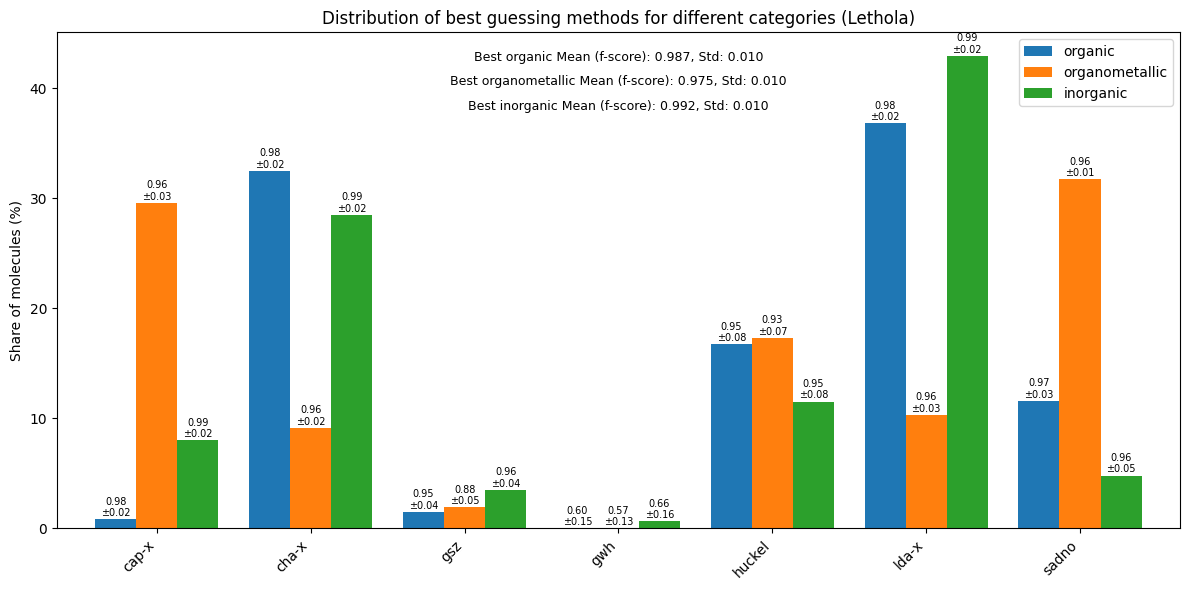

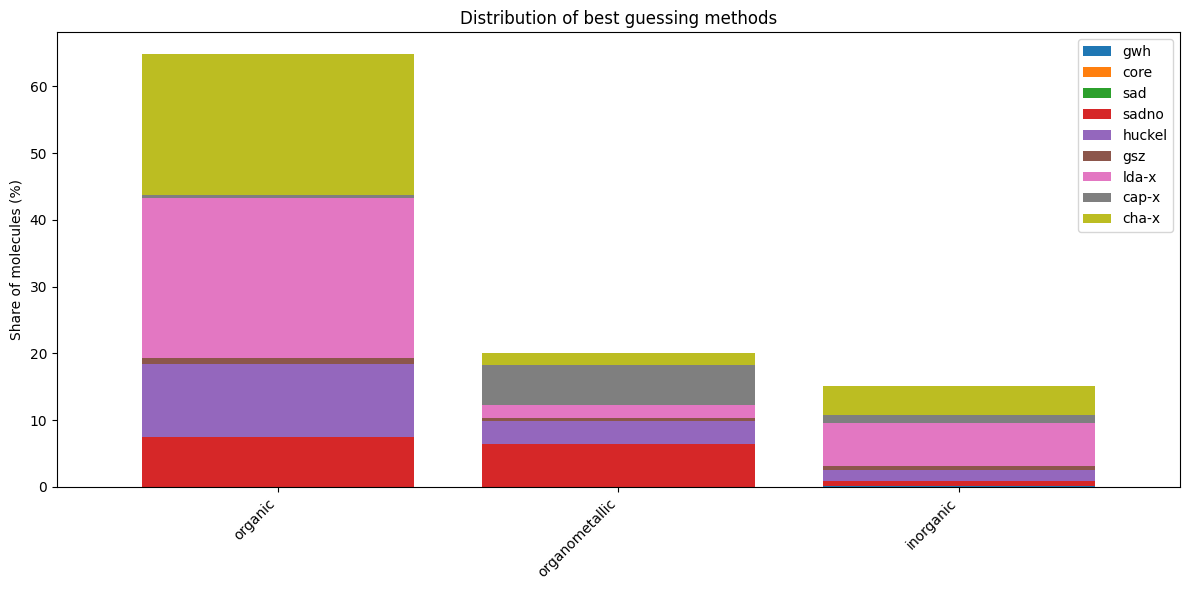

In [24]:
categories = ['organic', 'organometallic', 'inorganic']
# split into organic and inorganic
organic_data = lethola_data[lethola_data['organic'] == 'organic']
inorganic_data = lethola_data[lethola_data['organic'] == 'inorganic']
organometallic_data = lethola_data[lethola_data['organic'] == 'organometallic']

organic_metrics = get_max_metrics(organic_data, guessing_methods_lethola, "f-score", "Lethola")
inorganic_metrics = get_max_metrics(inorganic_data, guessing_methods_lethola, "f-score", "Lethola")
organometallic_metrics = get_max_metrics(organometallic_data, guessing_methods_lethola, "f-score", "Lethola")

metrics_dict = {'organic': organic_metrics, 'inorganic': inorganic_metrics, 'organometallic': organometallic_metrics}
print(f"Mean of methods (organic):\n{organic_metrics['mean_per_method']}")
print(f"Mean of methods (inorganic):\n{inorganic_metrics['mean_per_method']}")
print(f"Mean of methods (organometallic):\n{organometallic_metrics['mean_per_method']}")
included_org = organic_metrics["max_metric_ratios"][organic_metrics["max_metric_ratios"] > 0].index.tolist()
included_inorg = inorganic_metrics["max_metric_ratios"][inorganic_metrics["max_metric_ratios"] > 0].index.tolist()
included_metorg = organometallic_metrics["max_metric_ratios"][organometallic_metrics["max_metric_ratios"] > 0].index.tolist()
print(f"Note that {included_org} for organic, {included_metorg} for organometallic and {included_inorg} for inorganic are methods which performed best on at least one molecule")


plot_max_metric_ratios(metrics_dict, categories, lethola_data['organic'], filesuffix="organic_inorganic")

### Multiply things here: 
- Organic and Inorganic perform generally better (in f-score) combared to organometallic


## Distribution of f-scores for different guessing methods
Now let's take a look at the density of f-scores for different guessing methods

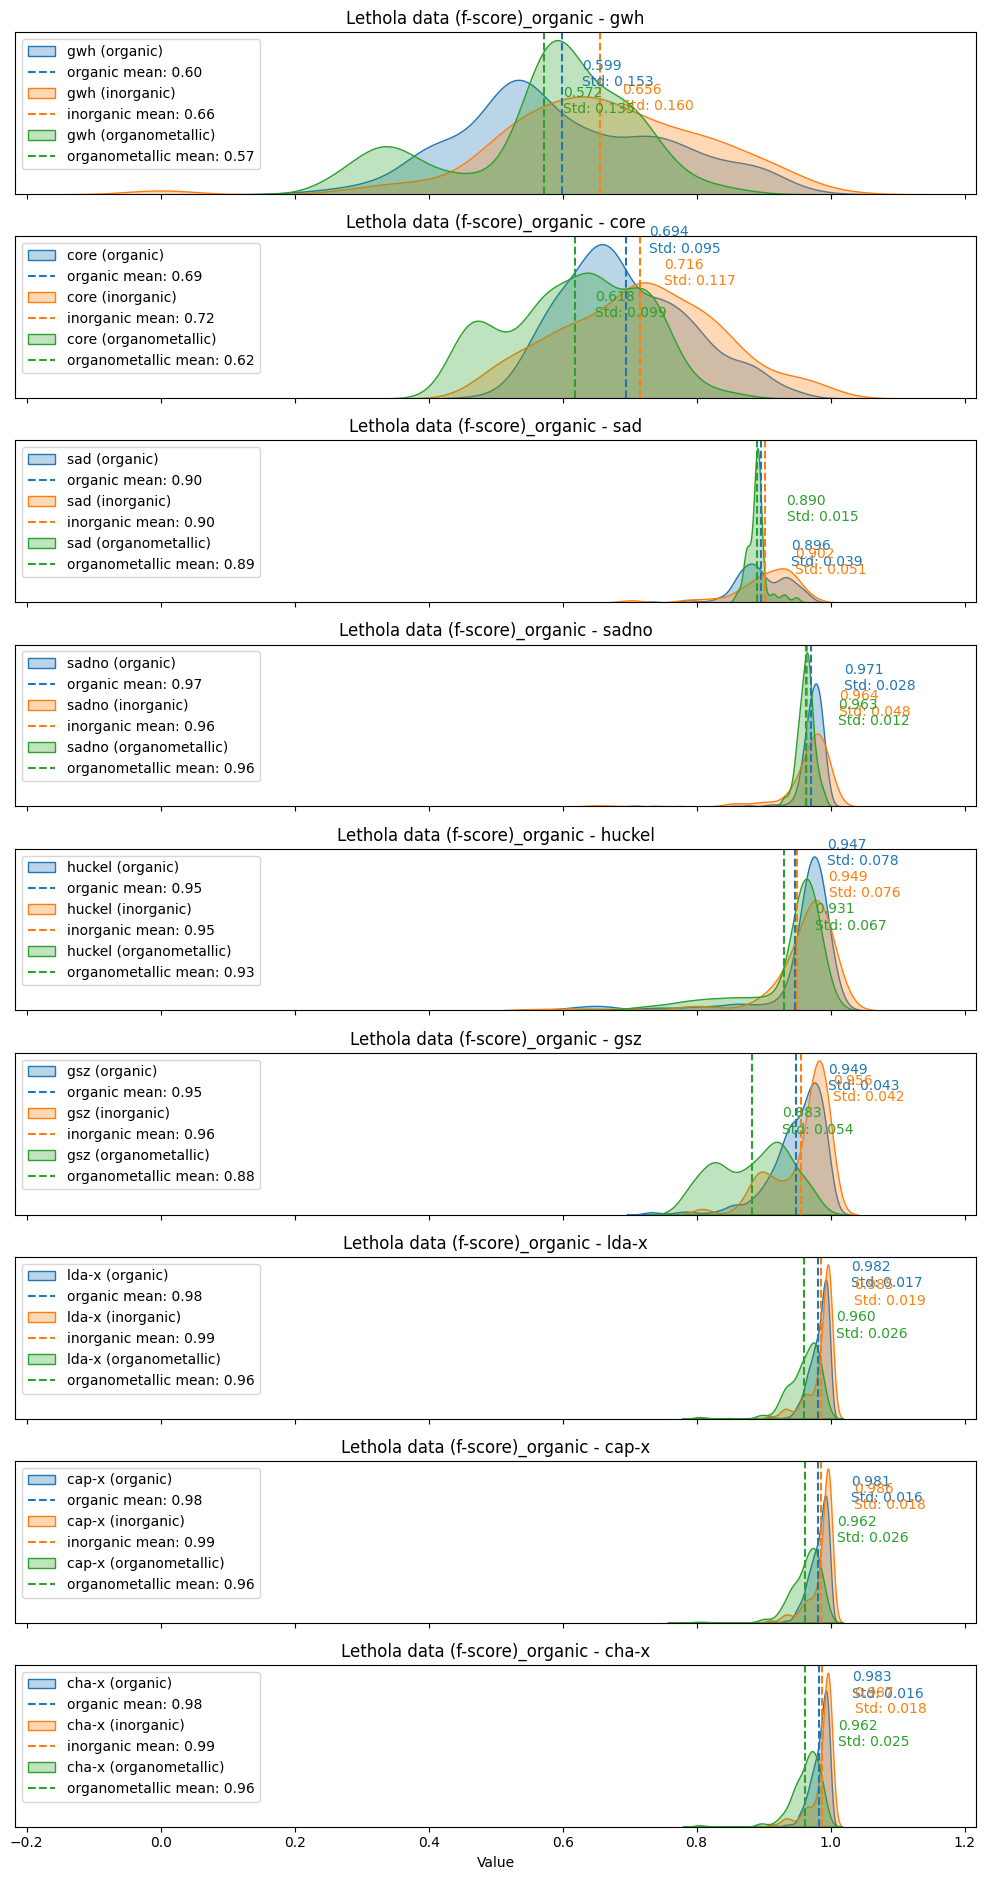

In [25]:
metrics = plot_stacked_density(lethola_data, guessing_methods_lethola, "organic", "Lethola data (f-score)_organic", return_metrics=True)

## Small vs. Big molecules
Furthermore, let's compare the f-scores for small to big molecules

-> tiny: 1-3 Atoms

-> small: 4-8 Atoms

-> medium: 9-15 Atoms

-> large: 16-50 Atoms

-> huge: 51+ Atoms (largest molecule in the dataset **has 28 atoms**)

size
tiny      1080
small      624
medium     304
large       64
Name: count, dtype: int64


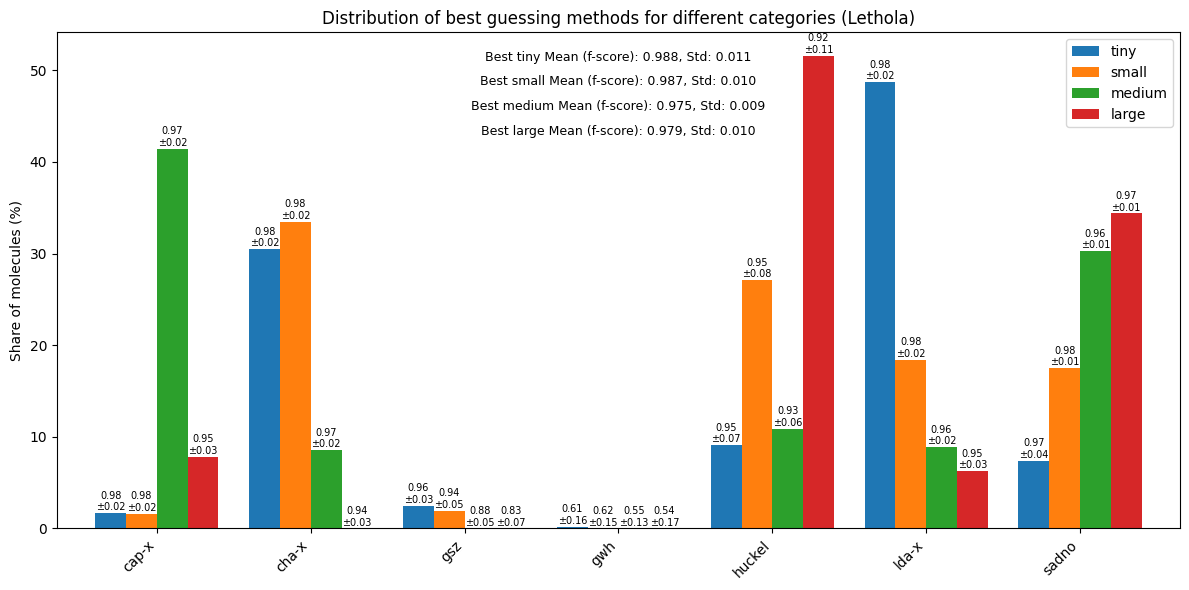

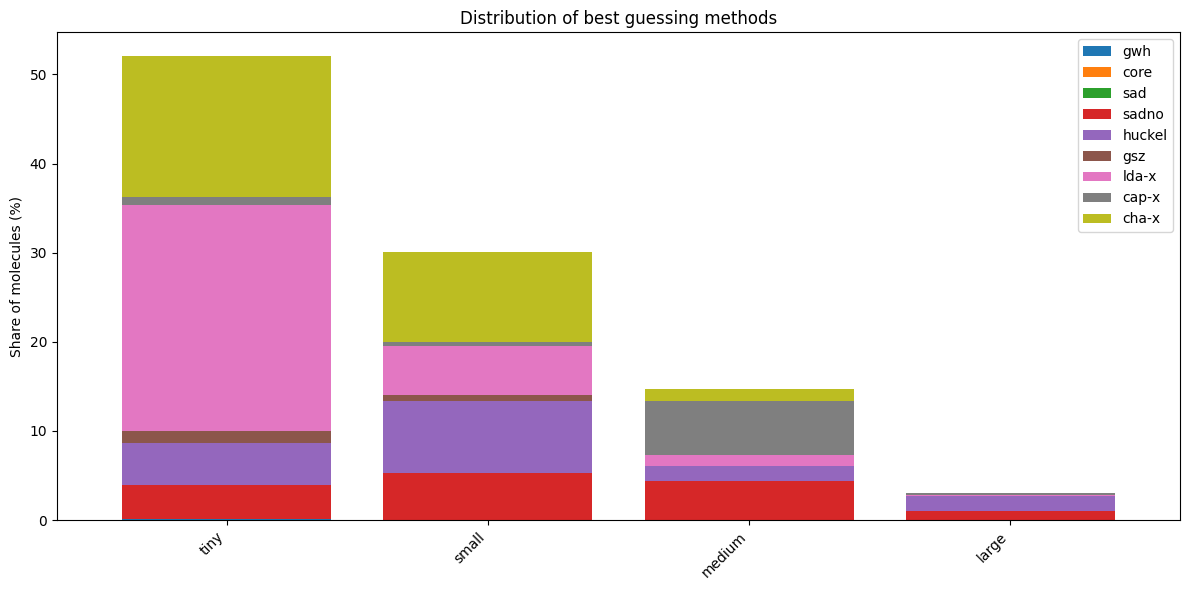

In [26]:
lethola_data["atom_count"] = lethola_data["smi"].map(get_atom_count)

Mol_sizes = {"tiny": (1, 3), "small": (4, 8), "medium": (9, 15), "large": (16, 50)}
lethola_data["size"] = lethola_data["atom_count"].map(lambda x: next((k for k, v in Mol_sizes.items() if v[0] <= x <= v[1]), 'huge'))
print(lethola_data["size"].value_counts())
# print(lethola_data["atom_count"].value_counts().sort_index())

size_metrics = {size: get_max_metrics(lethola_data[lethola_data["size"] == size], guessing_methods_lethola, "f-score", f"Lethola") for size in Mol_sizes.keys()}
plot_max_metric_ratios(size_metrics, Mol_sizes.keys(), lethola_data["size"], filesuffix="size")



-> Large (16-50) get the best f-scores using huckel or sadno

-> Medium (9-15) get the best f-scores mostly using cap-X and sadno

-> Small (4-8) is more varied and gets best f-scores using cha-x, huckel, ida-x and sadno

-> Tiny (1-3) gets the best f-scores using ida-x and cha-x

## Functional Groups

In [27]:
lethola_data['functional_group'].value_counts()

functional_group
(Fallback) Inorganic                656
(Fallback) Organic                  384
Alkene                              288
(Fallback) Organometallic           256
Halogenalkane                       112
Amine                                80
Alkyne                               56
Nitrile                              48
Alcohol                              40
Ketone                               24
Ether                                16
Thiol                                16
Ester, Ether                         16
Aldehyde, Ketone                     16
Pyrrole                               8
Furan                                 8
Thiophene                             8
Ether, Epoxide                        8
Alcohol, Carboxylic Acid, Ketone      8
Ether, Alkene                         8
Alcohol, Carboxylic Acid              8
Alcohol, Nitrile                      8
Name: count, dtype: int64

We can further group by functional groups and see if there are any patterns here. 

Mean of methods ((Fallback) Inorganic):
gwh       0.653279
core      0.724562
sad       0.904934
sadno     0.967838
huckel    0.965192
gsz       0.970723
lda-x     0.990046
cap-x     0.990215
cha-x     0.990759
dtype: float64
Mean of methods ((Fallback) Organic):
gwh       0.574755
core      0.673844
sad       0.881604
sadno     0.965292
huckel    0.931221
gsz       0.932654
lda-x     0.975940
cap-x     0.975104
cha-x     0.977299
dtype: float64
Mean of methods (Alkene):
gwh       0.553111
core      0.634503
sad       0.889559
sadno     0.971705
huckel    0.913663
gsz       0.893337
lda-x     0.960333
cap-x     0.960264
cha-x     0.962694
dtype: float64
Mean of methods ((Fallback) Organometallic):
gwh       0.582535
core      0.623262
sad       0.890922
sadno     0.961910
huckel    0.939324
gsz       0.901211
lda-x     0.969141
cap-x     0.971187
cha-x     0.972211
dtype: float64
Mean of methods (Halogenalkane):
gwh       0.667268
core      0.739384
sad       0.941429
sadno     0.98193

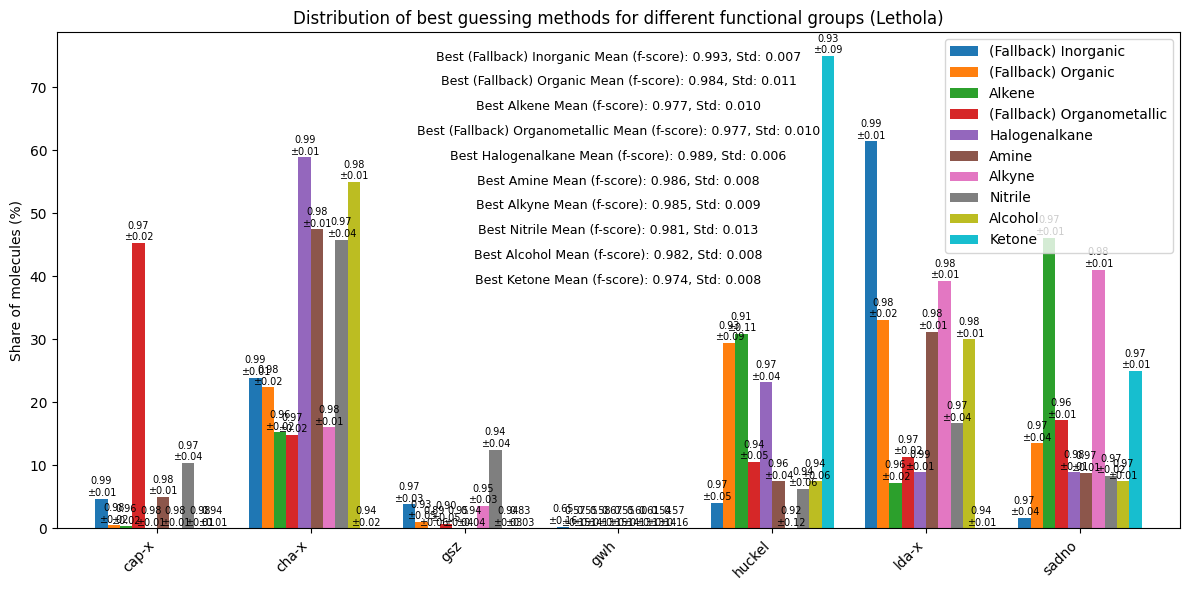

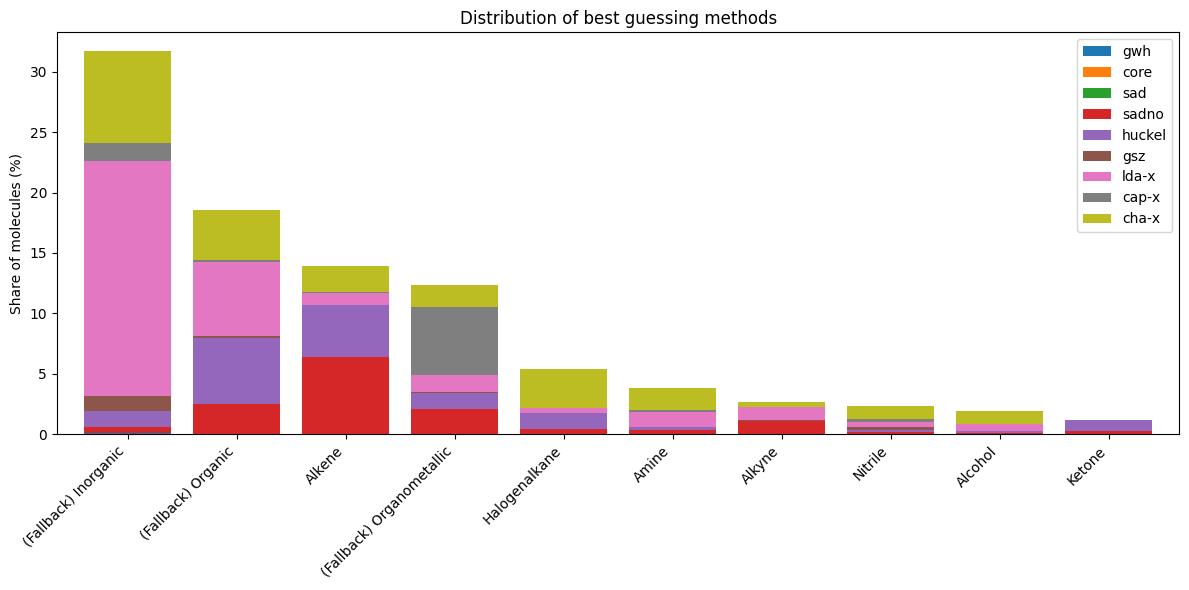

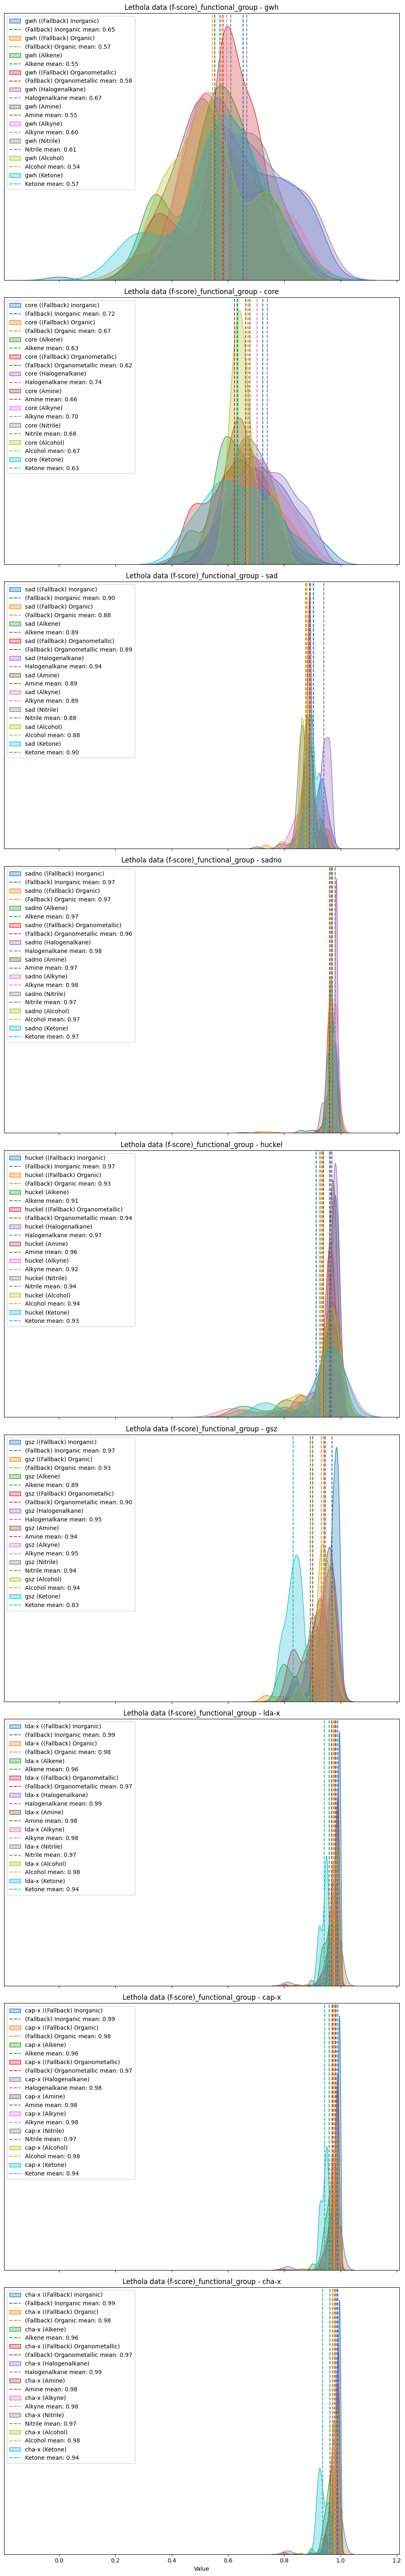

In [28]:
# (Fallback) Inorganic                656
# (Fallback) Organic                  384
# Alkene                              288
# (Fallback) Organometallic           256
# Halogenalkane                       112
# Amine                                80
# Alkyne                               56
# Nitrile                              48
# Alcohol                              40
# Ketone                               24
# Ether                                16
# Thiol                                16
functional_groups_to_use = ["(Fallback) Inorganic", "(Fallback) Organic", "Alkene", "(Fallback) Organometallic", "Halogenalkane", "Amine", "Alkyne", "Nitrile", "Alcohol", "Ketone"]#, "Ether", "Thiol"]
# functional_groups_to_use = ["Alkene", "Amine", "Alkyne", "Nitrile", "Alcohol", "Ketone", "Ether"]


# Perform analysis for functional groups
functional_group_metrics = {fg: get_max_metrics(lethola_data[lethola_data['functional_group'] == fg], guessing_methods_lethola, "f-score", "Lethola") for fg in functional_groups_to_use}

# Print mean of methods for each functional group
for fg, metrics in functional_group_metrics.items():
    print(f"Mean of methods ({fg}):\n{metrics['mean_per_method']}")

# Plot max metric ratios for functional groups
plot_max_metric_ratios(functional_group_metrics, functional_groups_to_use, lethola_data["functional_group"], title='Distribution of best guessing methods for different functional groups', filesuffix='functional_groups')

metrics = plot_stacked_density(lethola_data, guessing_methods_lethola, "functional_group", "Lethola data (f-score)_functional_group", category_filter = functional_groups_to_use, return_metrics=True)

<!-- ## Psi 4 recalc... (at least for most molecules) -->

## Psi4 recalc for most molecules

functional_group
(Fallback) Inorganic                656
(Fallback) Organic                  384
Alkene                              288
(Fallback) Organometallic           256
Halogenalkane                       112
Amine                                80
Alkyne                               56
Nitrile                              48
Alcohol                              40
Ketone                               24
Ether                                16
Thiol                                16
Ester, Ether                         16
Aldehyde, Ketone                     16
Pyrrole                               8
Furan                                 8
Thiophene                             8
Ether, Epoxide                        8
Alcohol, Carboxylic Acid, Ketone      8
Ether, Alkene                         8
Alcohol, Carboxylic Acid              8
Alcohol, Nitrile                      8
Name: count, dtype: int64


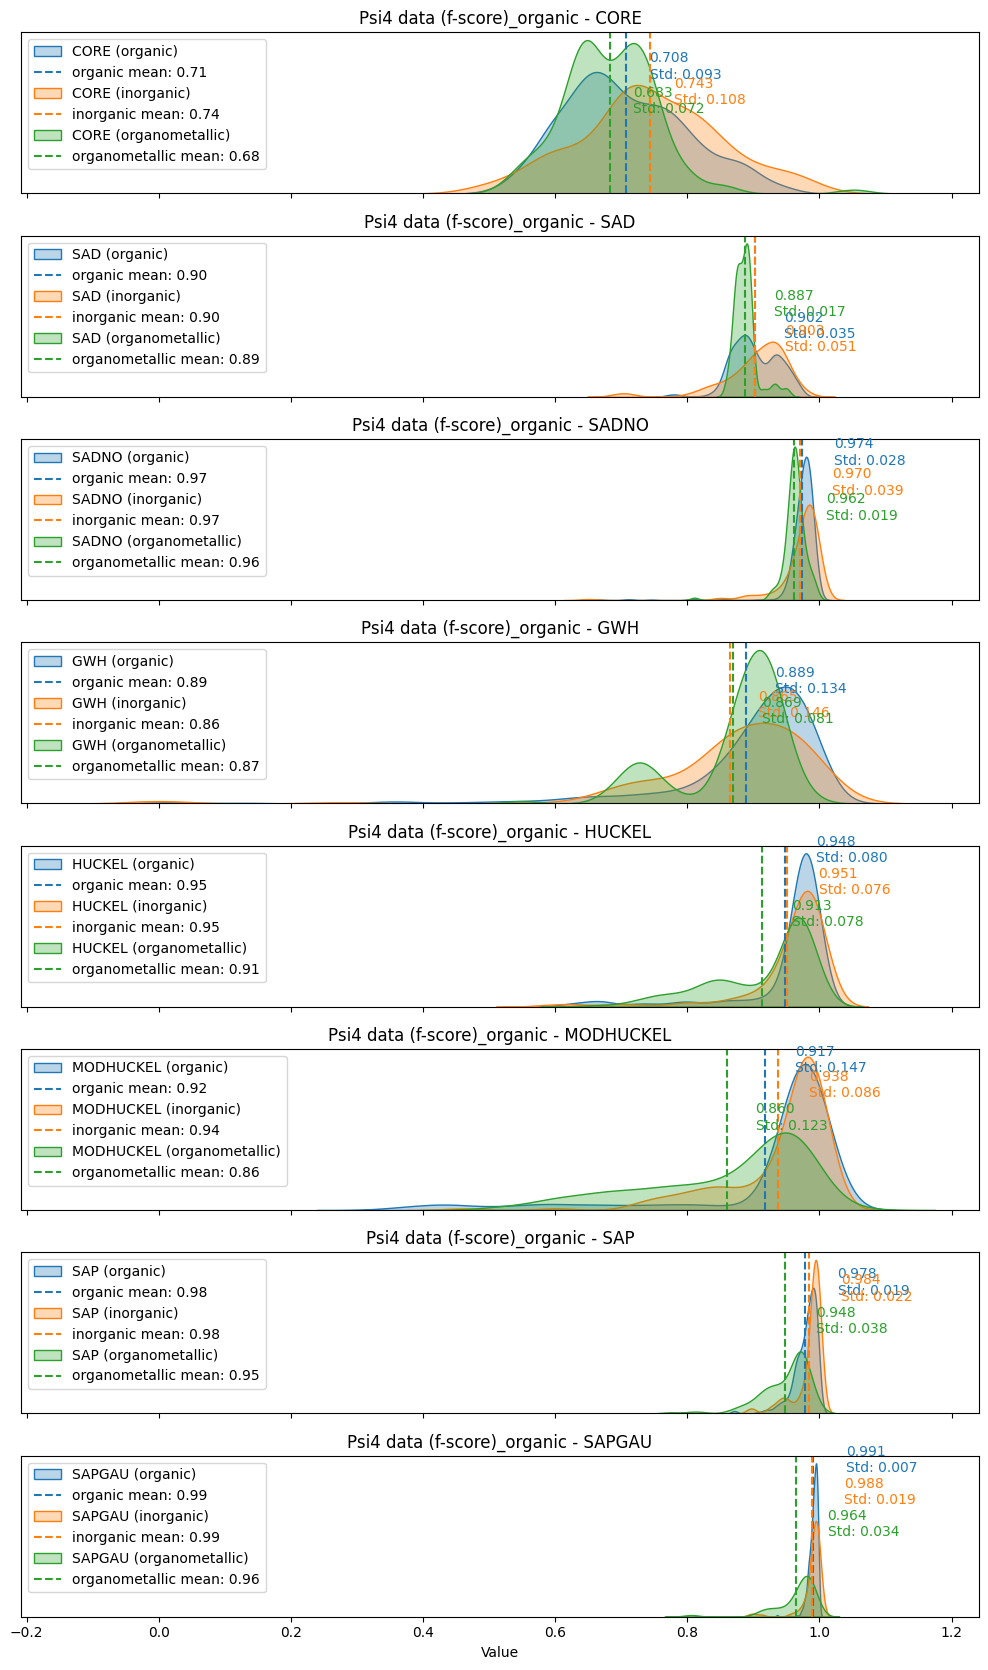

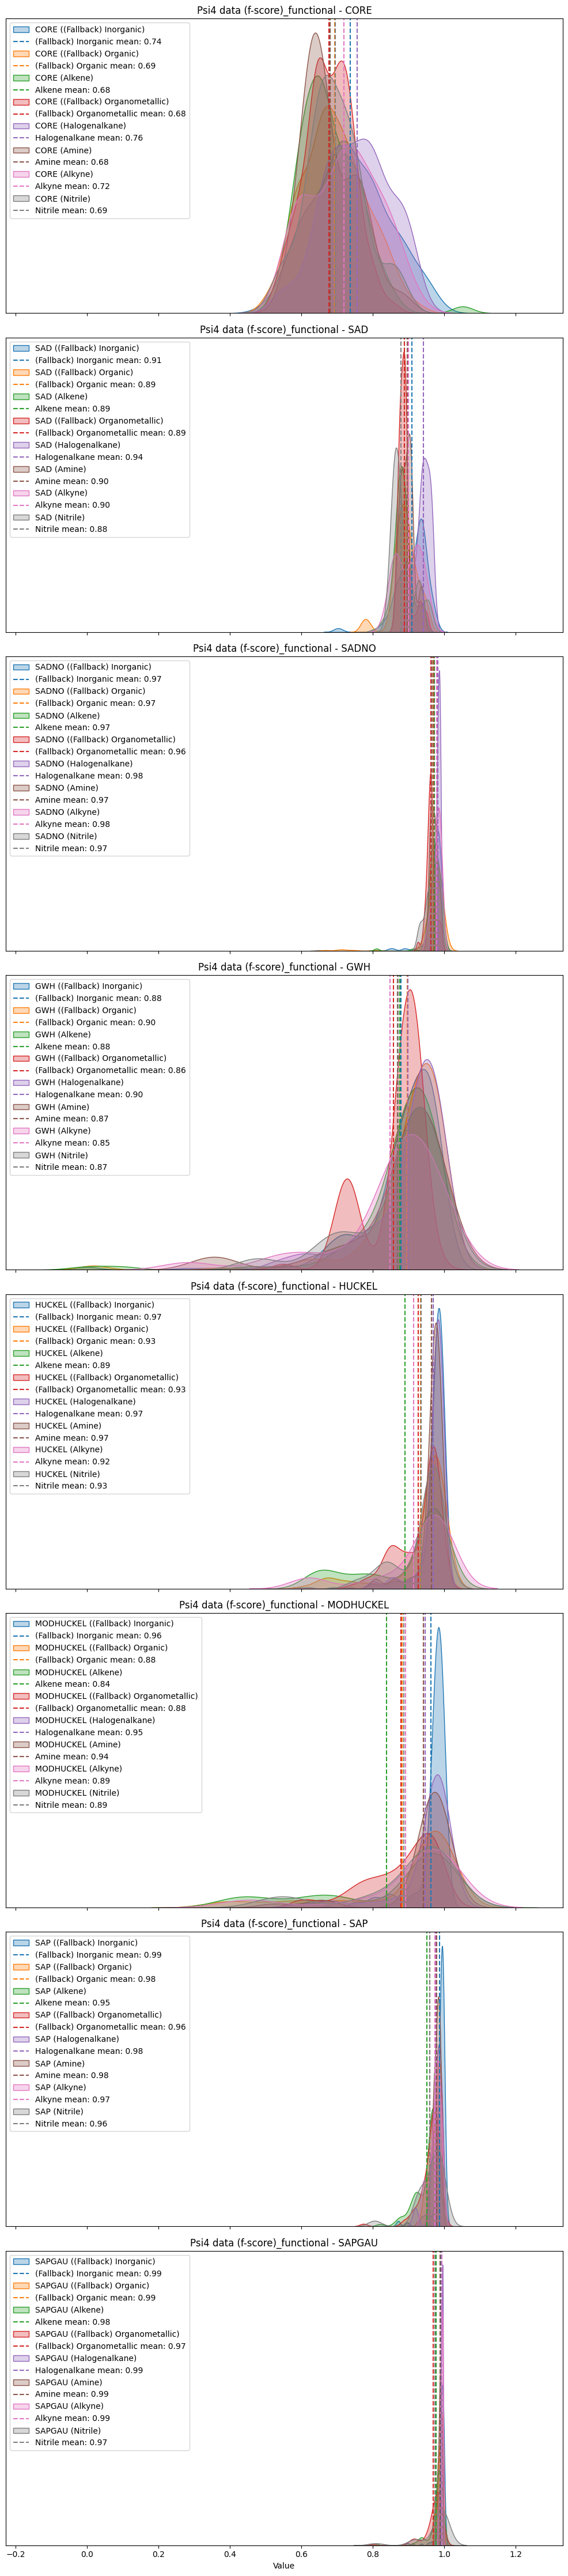

In [29]:
guessing_methods_psi4 = ["CORE", "SAD", "SADNO", "GWH", "HUCKEL", "MODHUCKEL", "SAP", "SAPGAU"]
vc = psi4_data["functional_group"].value_counts()
print(vc)
# plot_stacked_scatter(psi4_data, guessing_methods_psi4, "Psi4 data (f-score)")
metrics = plot_stacked_density(psi4_data, guessing_methods_psi4,"organic",  "Psi4 data (f-score)_organic", return_metrics=True)
metrics = plot_stacked_density(psi4_data, guessing_methods_psi4,"functional_group", "Psi4 data (f-score)_functional",category_filter= vc.index[:8].to_list(), return_metrics=True)

## PySCF recalc for many molecules